# 1. detect people

In [41]:
# based on: https://www.youtube.com/watch?v=Pb3opEFP94U&t=813s
# based on: https://colab.research.google.com/drive/1x-eMvFQTLBTr7ho9ZlYkHF0NmyUyAlxT?usp=sharing#scrollTo=Z_pe5XFayoHP

### import libraries

In [29]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.structures import Boxes

import detectron2
import cv2 as cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

### configure detector

In [30]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

In [31]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.DEVICE = "cpu"
predictor = DefaultPredictor(cfg)

### define function responsible for detected class reduction to one

In [32]:
def chooseOneClassFromAllDetected(initialPredictions, image):
    """
    Method responsible for reducing detected object classes to one particular

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: image to be processed
    """

    classes = initialPredictions["instances"].pred_classes
    scores = initialPredictions["instances"].scores
    boxes = initialPredictions["instances"].pred_boxes

    index_to_keep = (classes == 0).nonzero().flatten().tolist()

    classes_filtered = torch.tensor(np.take(classes.cpu().numpy(), index_to_keep))
    scores_filtered = torch.tensor(np.take(scores.cpu().numpy(), index_to_keep))
    boxes_filtered = Boxes(
        torch.tensor(np.take(boxes.tensor.cpu().numpy(), index_to_keep, axis=0))
    )

    obj = detectron2.structures.Instances(
        image_size=(image.shape[0], image.shape[1])
    )
    obj.set("pred_classes", classes_filtered)
    obj.set("scores", scores_filtered)
    obj.set("pred_boxes", boxes_filtered)

    return obj

### load an image

In [37]:
imagePath = "images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg"
image = cv2.imread(imagePath)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

### perform detection and make prediction boxes

In [38]:
predictions = predictor(image)
new_predictions = chooseOneClassFromAllDetected(initialPredictions=predictions, image=image)
prediction_boxes = [x.numpy() for x in list(new_predictions.pred_boxes)]

### make visualization part and extract image with boxes

In [39]:
viz = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output = viz.draw_instance_predictions(new_predictions.to("cpu"))

image_with_boxes = output.get_image()[:, :, ::-1]

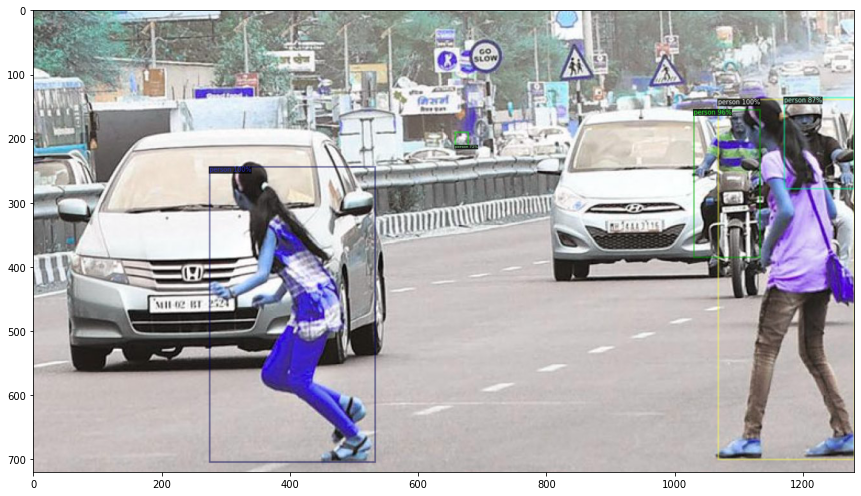

In [40]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_with_boxes)
plt.tight_layout()